In [8]:
import torch
import torch.nn as nn               #←
import torch.optim as optim         #←
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드 및 전처리

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # -1 to 1 범위로 정규화
])

In [10]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

Files already downloaded and verified


# Autoencoder 모델 정의

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder 부분
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),   # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128)  # latent space (압축된 표현)
        )
        
        # Decoder 부분
        self.decoder = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # 16x16 -> 32x32
            nn.Tanh()  # 0~1 범위로 출력
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# 모델 초기화
model = Autoencoder().cuda()

# 손실 함수와 최적화 알고리즘

In [12]:
criterion = nn.MSELoss()  # 평균 제곱 오차 (복원된 이미지와 원본 이미지 간의 차이)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# 학습 함수
def train_model(model, trainloader, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in trainloader:
            inputs, _ = data  # 레이블은 필요 없음
            inputs = inputs.cuda()

            # 손상된 이미지 생성 (노이즈 추가)
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            noisy_inputs = torch.clip(noisy_inputs, 0., 1.)  # 값이 0~1 사이로 유지되도록 조정

            optimizer.zero_grad()

            # 모델에 손상된 이미지 입력
            outputs = model(noisy_inputs)
            
            # 손실 계산
            loss = criterion(outputs, inputs)  # 원본 이미지와 복원된 이미지 간의 차이
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader)}')

# 모델 학습
train_model(model, trainloader, epochs=5)

Epoch [1/5], Loss: 0.09763064478402553
Epoch [2/5], Loss: 0.06566657500860788
Epoch [3/5], Loss: 0.05744375106033005
Epoch [4/5], Loss: 0.05315166025820291
Epoch [5/5], Loss: 0.04956376771716511


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7655043..0.76608497].


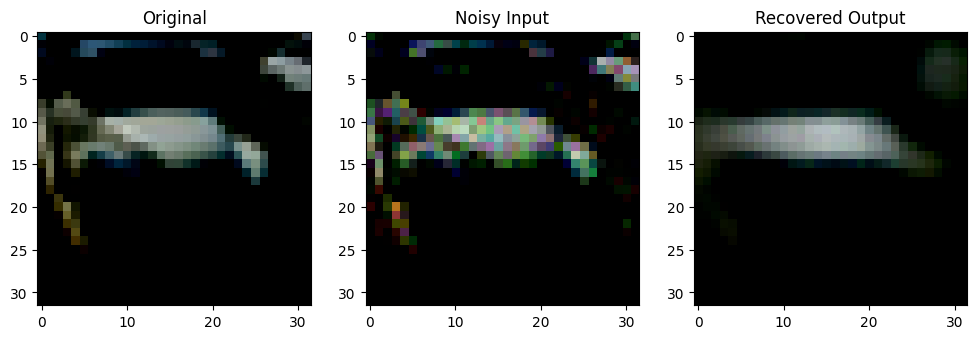

In [14]:
# 이미지 결과 확인 함수
def show_images(original, noisy, output):
    # 결과 이미지를 시각화
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    ax[0].imshow(original.permute(1, 2, 0).cpu().detach().numpy())
    ax[0].set_title('Original')
    ax[1].imshow(noisy.permute(1, 2, 0).cpu().detach().numpy())
    ax[1].set_title('Noisy Input')
    ax[2].imshow(output.permute(1, 2, 0).cpu().detach().numpy())
    ax[2].set_title('Recovered Output')
    
    plt.show()

# 학습된 모델로 테스트 이미지 확인
model.eval()
with torch.no_grad():
    data_iter = iter(trainloader)
    images, _ = next(data_iter)
    noisy_images = images + 0.1 * torch.randn_like(images)
    noisy_images = torch.clip(noisy_images, 0., 1.)
    
    outputs = model(noisy_images.cuda())
    
    # 첫 번째 배치의 이미지 1개만 보여주기
    show_images(images[0], noisy_images[0], outputs[0].cpu())
